# Analysis and visualization of spatial transcriptomics data

In [4]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from crowflow import StochasticClusteringRunner
from sknetwork.clustering import Leiden

## Reading the data

We will use a Visium spatial transcriptomics dataset of the human lymphnode, which is publicly available from the 10x genomics website: [link](https://support.10xgenomics.com/spatial-gene-expression/datasets/1.0.0/V1_Human_Lymph_Node).

In [5]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

/Users/macbookpro/Desktop/Desktop_rafa/RA/crow/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/macbookpro/Desktop/Desktop_rafa/RA/crow/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
adata.obs

in_tissue  array_row  array_col  n_genes_by_counts  \
AAACAAGTATCTCCCA-1          1         50        102               6732   
AAACAATCTACTAGCA-1          1          3         43               6759   
AAACACCAATAACTGC-1          1         59         19               8590   
AAACAGAGCGACTCCT-1          1         14         94               7236   
AAACAGCTTTCAGAAG-1          1         43          9               6890   
...                       ...        ...        ...                ...   
TTGTTTCACATCCAGG-1          1         58         42               5771   
TTGTTTCATTAGTCTA-1          1         60         30               6354   
TTGTTTCCATACAACT-1          1         45         27               6517   
TTGTTTGTATTACACG-1          1         73         41               4476   
TTGTTTGTGTAAATTC-1          1          7         51               7183   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAACAAGTATCTCCCA-1                 8.814776       27944.0           10.237993   
AAACAATCTACTAGCA-1                 8.818778       25685.0           10.153702   
AAACACCAATAACTGC-1                 9.058470       42942.0           10.667629   
AAACAGAGCGACTCCT-1                 8.886962       31916.0           10.370894   
AAACAGCTTTCAGAAG-1                 8.837971       30932.0           10.339579   
...                                     ...           ...                 ...   
TTGTTTCACATCCAGG-1                 8.660774       19649.0            9.885833   
TTGTTTCATTAGTCTA-1                 8.756997       21557.0            9.978502   
TTGTTTCCATACAACT-1                 8.782323       22175.0           10.006766   
TTGTTTGTATTACACG-1                 8.406708       12268.0            9.414831   
TTGTTTGTGTAAATTC-1                 8.879612       30022.0           10.309719   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACAAGTATCTCCCA-1                   33.241483                    41.071429   
AAACAATCTACTAGCA-1                   23.507884                    33.965349   
AAACACCAATAACTGC-1                   22.502445                    31.770761   
AAACAGAGCGACTCCT-1                   21.948239                    31.990224   
AAACAGCTTTCAGAAG-1                   26.357817                    38.132032   
...                                        ...                          ...   
TTGTTTCACATCCAGG-1                   27.131152                    35.950939   
TTGTTTCATTAGTCTA-1                   24.238067                    32.263302   
TTGTTTCCATACAACT-1                   21.506201                    30.593010   
TTGTTTGTATTACACG-1                   24.078904                    34.268014   
TTGTTTGTGTAAATTC-1                   24.938379                    35.124242   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
AAACAAGTATCTCCCA-1                    48.375322                    57.572287   
AAACAATCTACTAGCA-1                    42.631886                    53.054312   
AAACACCAATAACTGC-1                    40.584975                    50.815053   
AAACAGAGCGACTCCT-1                    41.101642                    52.603710   
AAACAGCTTTCAGAAG-1                    47.575327                    57.590844   
...                                         ...                          ...   
TTGTTTCACATCCAGG-1                    44.429742                    55.000254   
TTGTTTCATTAGTCTA-1                    40.265343                    51.152758   
TTGTTTCCATACAACT-1                    39.098083                    50.119504   
TTGTTTGTATTACACG-1                    43.193675                    54.964134   
TTGTTTGTGTAAATTC-1                    43.484778                    53.767237   

                    total_counts_mt  log1p_total_counts_mt  pct_counts_mt  
AAACAAGTATCTCCCA-1            248.0               5.517453       0.887489  
AAACAATCTACTAGCA-1            239.0               5.480639       0.930504  
AAACACCAATAACTGC-1  

## QC and preprocessing

Let's perform some basic filtering of spots based on total counts and expressed genes.

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

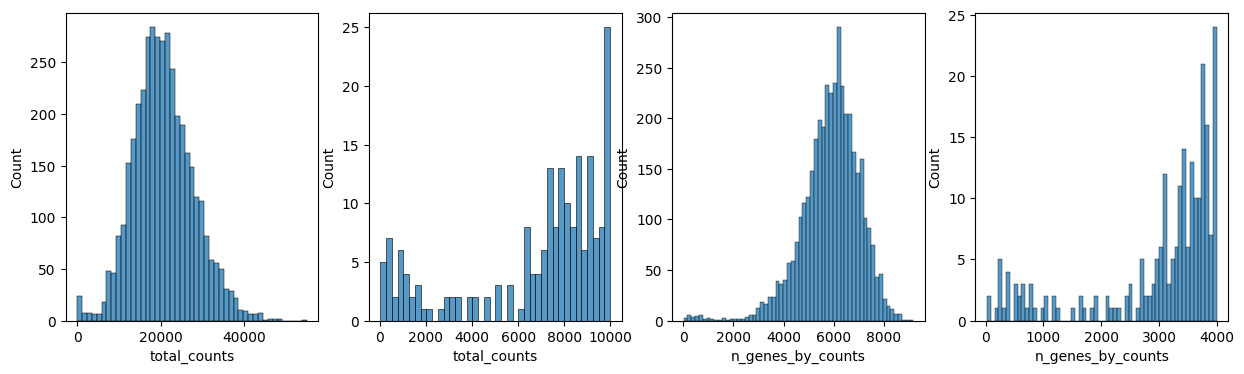

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)

In [8]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

#cells after MT filter: 3861


Let's normalize Visium counts data and detect highly-variable genes.

In [9]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

## Clustering

To embed and cluster the manifold encoded by transcriptional similarity, we proceed as in the standard clustering tutorial.

In [10]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [11]:
adjacency_matrix = adata.obsp["connectivities"]

In [12]:
adjacency_matrix

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 89990 stored elements and shape (3861, 3861)>

In [13]:
runner = StochasticClusteringRunner(
    clustering_algo=Leiden,
    parameter_name_seed="random_state",
    n_runs=30
)

results = runner.run(adjacency_matrix)

We plot some covariates to check if there is any particular structure in the UMAP associated with total counts and detected genes.

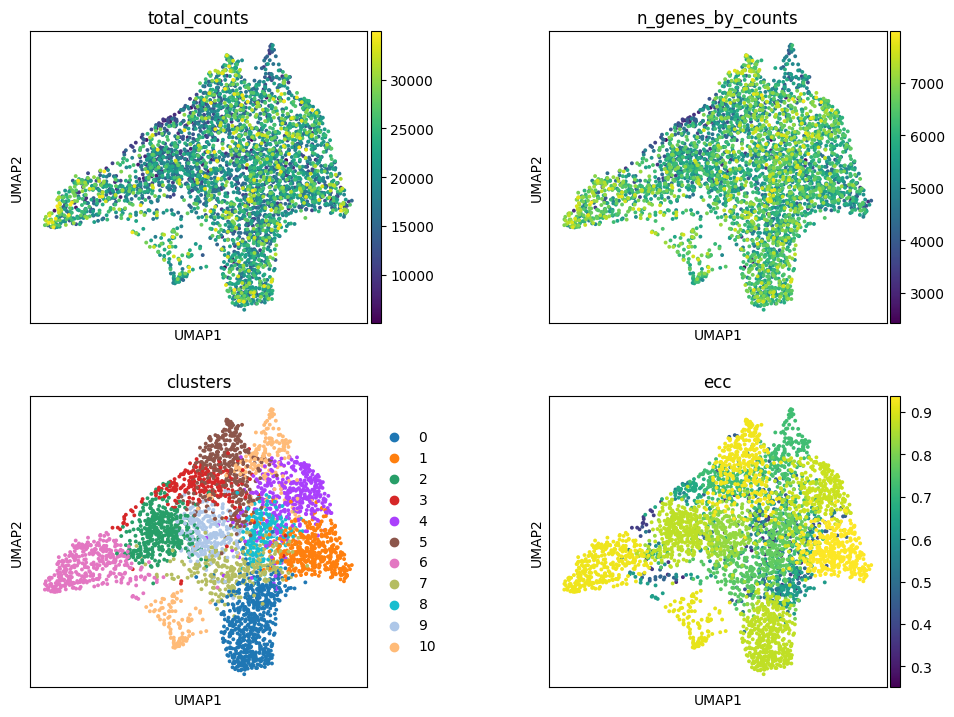

In [14]:
adata.obs["ecc"] = results["ecc"]
adata.obs["clusters"] = pd.Categorical(results["majority_voting_labels"])

plt.rcParams["figure.figsize"] = (4, 4)  # Adjust size to fit 2x2 grid

# Plot UMAP with a 2x2 grid
sc.pl.umap(
    adata,
    color=["total_counts", "n_genes_by_counts", "clusters", "ecc"],
    wspace=0.4,
    ncols=2  # Specify 2 columns
)

Let's visualise the clustering in the spatial coordinates.

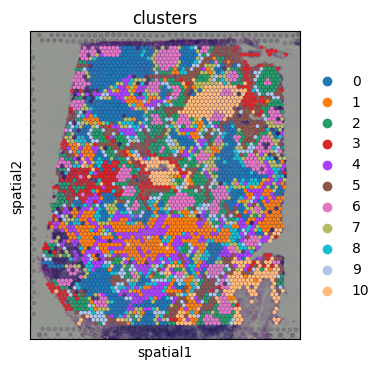

In [15]:
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1.5)

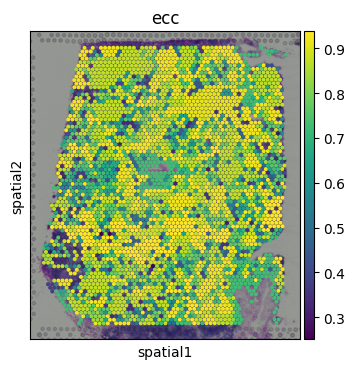

In [16]:
sc.pl.spatial(adata, img_key="hires", color="ecc", size=1.5)

- relatively stable partitioning
- would have been better to go with higher number of clusters
- standard approaches developed for scrna-seq will not be applicable directly to spatial because you are not taking into account the spatial information (it forms a heterogeneous input for the clustering algorithm). 
- important to embed the spatial information (coordinates) into clustering algorithm.

neg
- cluster 9 have scattered points. 

perhaps increase resolution to see if it increases stability --> compare with higher number of clusters. Crow ready to embed information from spatial clustering and assess the stability of the partitioning.

Spots belonging to the same cluster in gene expression space often co-occur in spatial dimensions. For instance, spots belonging to cluster 5 are often surrounded by spots belonging to cluster 0.

In [32]:
import numpy as np
from crow import ParameterSearcher

np.random.seed(42)

# Find the optimal parameters based on ECC - similar to fine tuning in supervised learning.
param_grid = {"resolution": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], "modularity": ["Dugue", "Newman"]}

parameter_searcher = ParameterSearcher(
    clustering_algo=Leiden,
    parameter_name_seed="random_state",
    param_grid=param_grid,
    n_runs=30,
    verbose=True,
)
searcher_results_ecc_df, stochastic_clustering_results = parameter_searcher.run(adjacency_matrix)

Testing parameters: {'resolution': 0.2, 'modularity': 'Dugue'}

 Median ECC:  0.7779679550122268
--------------------------------------------------------------
Testing parameters: {'resolution': 0.2, 'modularity': 'Newman'}

 Median ECC:  0.7403105420188038
--------------------------------------------------------------
Testing parameters: {'resolution': 0.3, 'modularity': 'Dugue'}

 Median ECC:  0.9142899579177847
--------------------------------------------------------------
Testing parameters: {'resolution': 0.3, 'modularity': 'Newman'}

 Median ECC:  0.8575759317476065
--------------------------------------------------------------
Testing parameters: {'resolution': 0.4, 'modularity': 'Dugue'}

 Median ECC:  0.8779579550542538
--------------------------------------------------------------
Testing parameters: {'resolution': 0.4, 'modularity': 'Newman'}

 Median ECC:  0.8844515439427381
--------------------------------------------------------------
Testing parameters: {'resolution': 0.

In [ ]:
from crow import plot_heatmap

plot_heatmap(searcher_results_ecc_df)

In [25]:
from crow import plot_heatmap

plot_heatmap(searcher_results_ecc_df)

Selected keys for visualization: resolution, modularity
Creating DataFrame from parameter search results...
No duplicates found. Proceeding without aggregation.


TODO: examine np.random.seed() to check if it fixes problem with leiden.

In [26]:
adata.obs["ecc_optimized"] = stochastic_clustering_results['resolution_0.4_modularity_Newman']['ecc']
adata.obs["clusters_optimized"] = pd.Categorical(stochastic_clustering_results['resolution_0.4_modularity_Newman']['majority_voting_labels'])

sc.pl.umap(
    adata,
    color=["total_counts", "n_genes_by_counts", "clusters_optimized", "ecc_optimized"],
    wspace=0.4,
    ncols=2  # Specify 2 columns
)

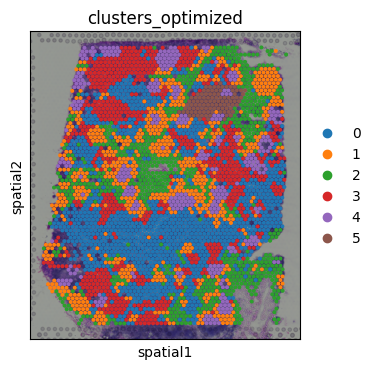

In [27]:
sc.pl.spatial(adata, img_key="hires", color="clusters_optimized", size=1.5)

TODO: 
- think of metric on how grouped the clusters are. Nearest neighbors approach. 
- Use same colour scheme for representing different clustrs.

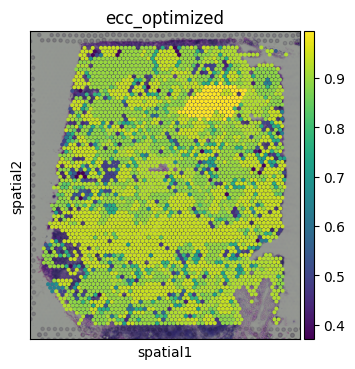

In [28]:
sc.pl.spatial(adata, img_key="hires", color="ecc_optimized", size=1.5)

much better, except cluster 8.

- ask eleanor if there is a way to assess the stability of partitioning from spatial perspective (go row by row and see how sparse the clusters are). Irina discussed an idea based on nearest-neighbors. take every single point on the spatial representation adn take the n nearest neighbors - check if all the neighbors are same/different cluster. the more homogeneity you see, the better.

In [29]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def compute_local_spatial_consistency(coords, labels, k=10, eps=1e-6):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(coords)
    distances, indices = nbrs.kneighbors(coords)
    # Exclude the point itself (first neighbor)
    distances = distances[:, 1:]
    indices = indices[:, 1:]
    
    lsc_scores = []
    for i in range(coords.shape[0]):
        # Inverse-distance weights
        weights = 1.0 / (distances[i] + eps)
        same_label = (labels[indices[i]] == labels[i]).astype(float)
        lsc = np.sum(weights * same_label) / np.sum(weights)
        lsc_scores.append(lsc)
    return np.mean(lsc_scores), lsc_scores

coords = adata.obsm['spatial']
labels = adata.obs["clusters_optimized"]

# Compute the homogeneity metric - i am using k=10
overall_homogeneity, per_point_homogeneity = compute_local_spatial_consistency(adata.obsm['spatial'], adata.obs["clusters"], k=10)
overall_homogeneity_optimised, per_point_homogeneity_optimised = compute_local_spatial_consistency(adata.obsm['spatial'], adata.obs["clusters_optimized"], k=10)


/var/folders/qz/79cxtdf52xgbtd4wqmwfvy0h0000gn/T/ipykernel_25183/1406017878.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/qz/79cxtdf52xgbtd4wqmwfvy0h0000gn/T/ipykernel_25183/1406017878.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/qz/79cxtdf52xgbtd4wqmwfvy0h0000gn/T/ipykernel_25183/1406017878.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/qz/79cxtdf52xgbtd4wqmwfvy0h0000gn/T/ipyker

In [30]:
overall_homogeneity

np.float64(0.42314691929339215)

In [31]:
overall_homogeneity_optimised

np.float64(0.5989496479766381)